## Results

episodic_only
- mean 44.56
- std 1.85

semantic_only
- mean 55.72
- std 1.61

random
- mean 37.64 
- std 2.16

dqn, pretrained, no ddqn, no dueling (w/ warm_start)
- mean 108.2
- std 5.01

dqn, no ddqn, no dueling (w/ warm_start)
- mean 91.28
- std 8.43

The code with AAAI paper (not_pretrained, pretrained):

- DQN:            110.7, 89.3
- DDQN:           108.2, 90.2
- Dueling DQN:    102.7, 81.4
- Dueling DDQN:   109.3, 89.0

After writing tests
- pre_trained       103.84 +- 5.34
- not_pre_trained   83.96 +- 4.21

After "fixing" the pre-filling of the replay buffer
- pre_trained       101.16 +- 6.56
- not_pre_trained   89.35 +- 8.45

After refactoring (moving some class methods to utils.py)
- pre_trained       105.6 +- 7.33
- not_pre_trained   82.2 +- 19.48

Training for 32 episodes (15-Nov-2023)
- pre_trained       103.3 +- 3.2
- not_pre_trained   93.5  +- 3.8
  
Training for 32 episodes, DDQN + Dueling (16-Nov-2023)
- pre_trained       101.5 +- 4.4
- not_pre_trained   88.8 +- 7.9

Training for 32 episodes, DDQN (16-Nov-2023)
- pre_trained       97.5 +- 4.2
- not_pre_trained   80.9 +- 6.6

Training for 32 episodes, Dueling (16-Nov-2023)
- pre_trained       97.5 +- 5.4
- not_pre_trained   83.0 +- 6.3

Training for 32 episodes, fix the last state issue (26-Nov-2023)
- pre_trained       
- not_pre_trained   


## Training RL agents

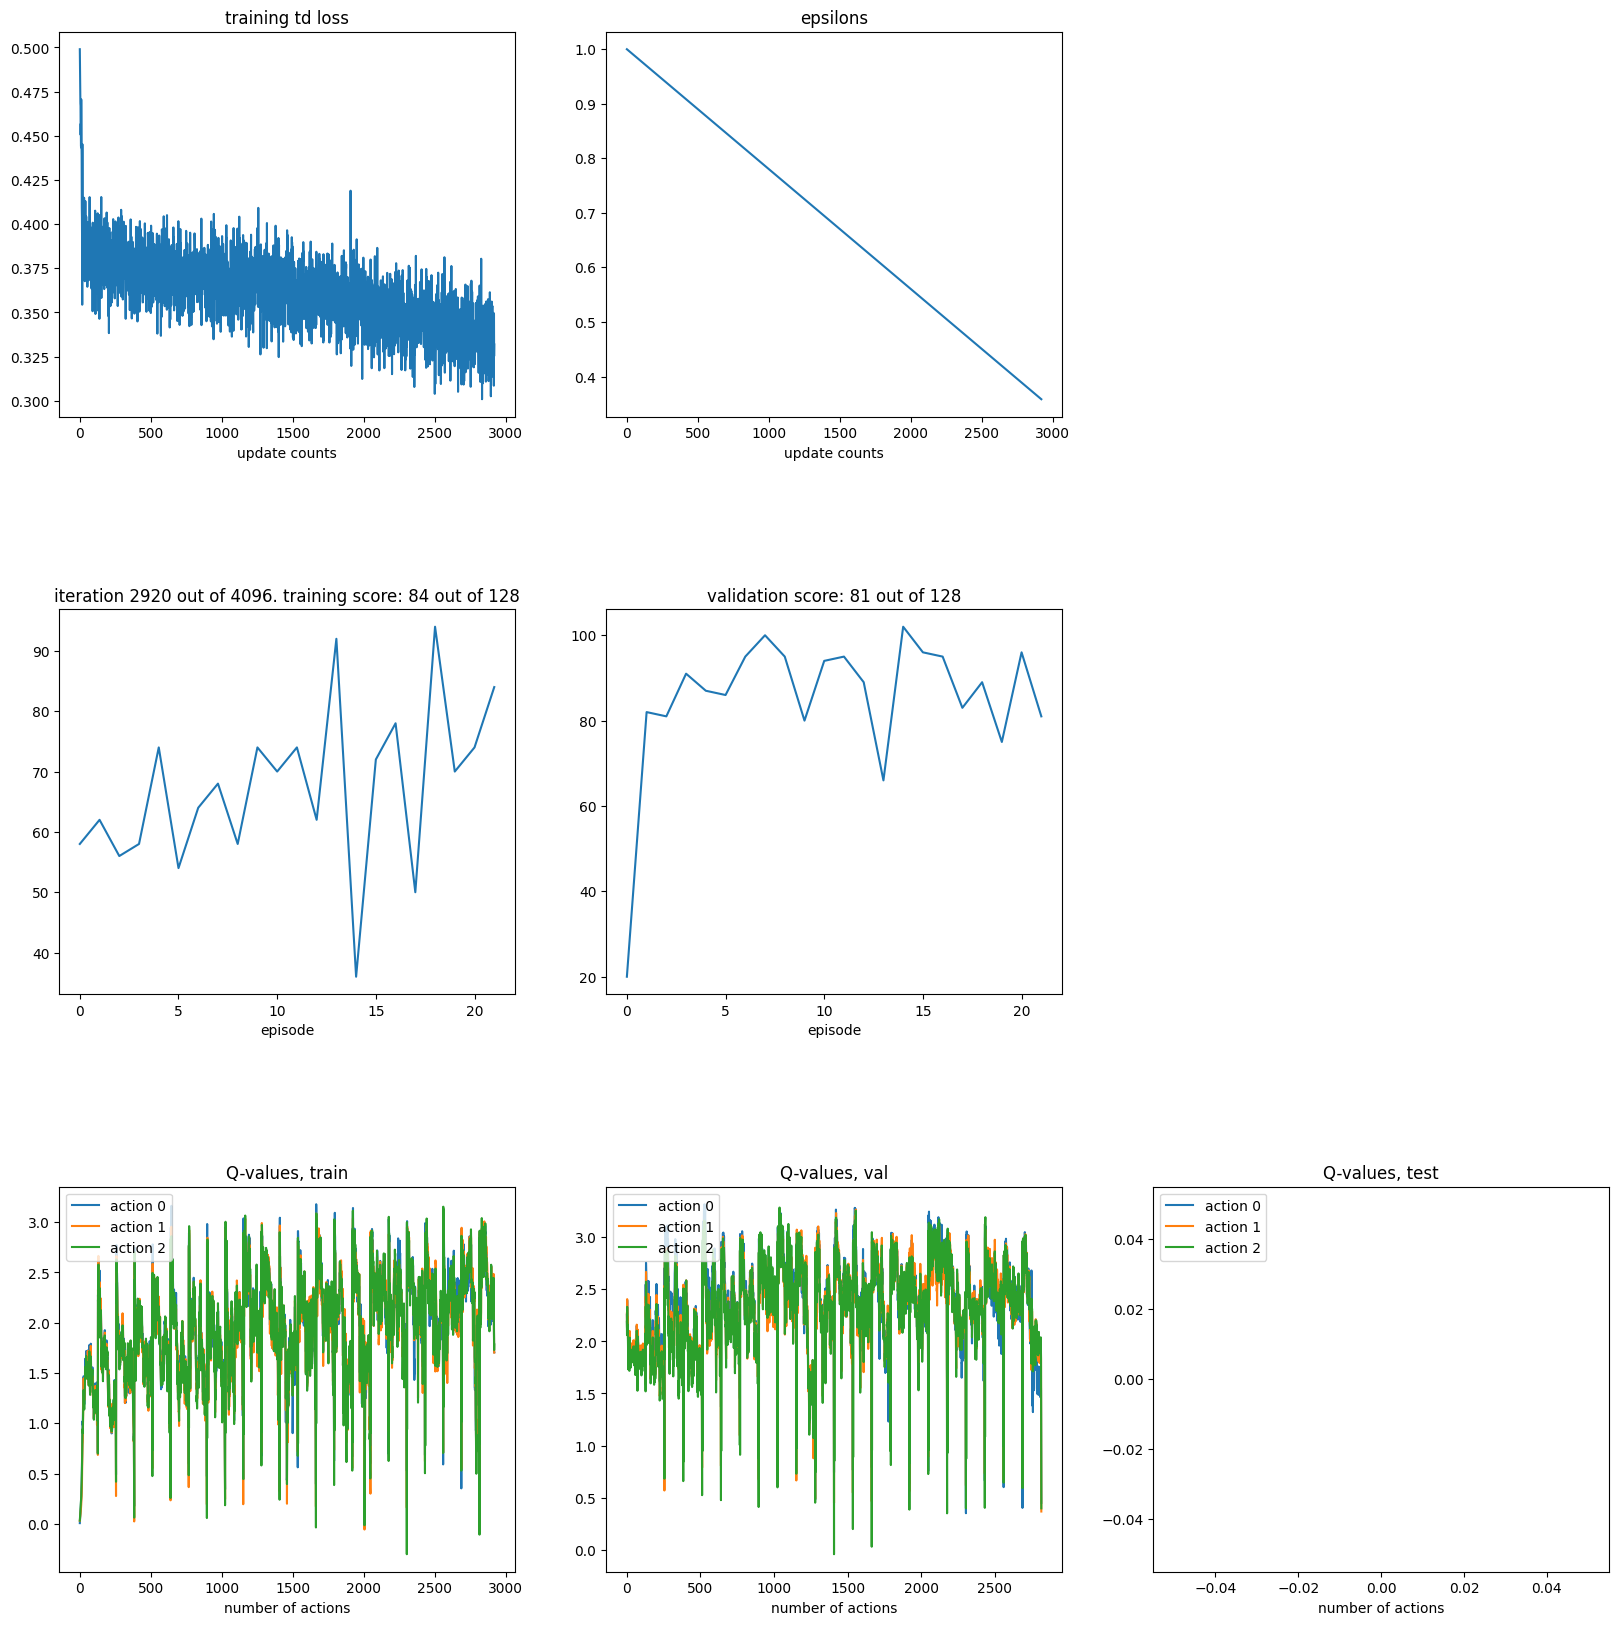

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent import DQNAgent

for pretrain_semantic in [True]:
    for test_seed in [2, 3, 4]:
        all_params = {
            "env_str": "room_env:RoomEnv-v1",
            "des_size": "l",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 4096,
            "gamma": 0.65,
            "capacity": {"episodic": 16, "semantic": 16, "short": 1},
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 32,
                "v1_params": {
                    "include_human": "sum",
                    "human_embedding_on_object_location": False,
                },
                "v2_params": None,
            },
            "num_iterations": 4096,
            "replay_buffer_size": 131072,
            "warm_start": 131072,
            "batch_size": 1024,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
            "ddqn": False,
            "dueling_dqn": False,
            "default_root_dir": "./training_results/32-episodes-l-fix-terminal-state/",
        }

        agent = DQNAgent(**all_params)
        agent.train()

## Testing hand-crafted agents

In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

from tqdm.auto import tqdm

from agent import HandcraftedAgent

for policy in tqdm(["random", "episodic_only", "semantic_only"]):
    for test_seed in [0, 1, 2, 3, 4]:
        all_params = {
            "env_str": "room_env:RoomEnv-v1",
            "policy": policy,
            "num_samples_for_results": 10,
            "seed": test_seed,
        }
        if policy == "random":
            all_params["capacity"] = {"episodic": 16, "semantic": 16, "short": 1}
        elif policy == "episodic_only":
            all_params["capacity"] = {"episodic": 32, "semantic": 0, "short": 1}
        else:
            all_params["capacity"] = {"episodic": 0, "semantic": 32, "short": 1}

        all_params["seed"] = test_seed
        agent = HandcraftedAgent(**all_params)
        agent.test()